In [639]:
import jax
import jax.numpy as jnp
import optax
import functools
import numpy as np

import haiku as hk
import numpyro
import matplotlib.pyplot as plt
import os
rngseed = 42

# `Optax` L2 loss example

In [640]:
@functools.partial(jax.vmap, in_axes=(None, 0))
def network(params, x):
    return jnp.dot(params, x)

def compute_loss(params, x, y):
    y_pred = network(params, x)
    loss = jnp.mean(optax.l2_loss(y_pred, y))
    return loss

In [149]:
rngkey = jax.random.PRNGKey(rngseed)
target_params = jnp.array([-.5, 1.0])
num_training_data = 16

X = jax.random.normal(rngkey, (num_training_data, 2))
Y = jnp.sum(X * target_params, axis=-1)
print(f"X.shape={X.shape}, Y.shape={Y.shape}")

X.shape=(16, 2), Y.shape=(16,)


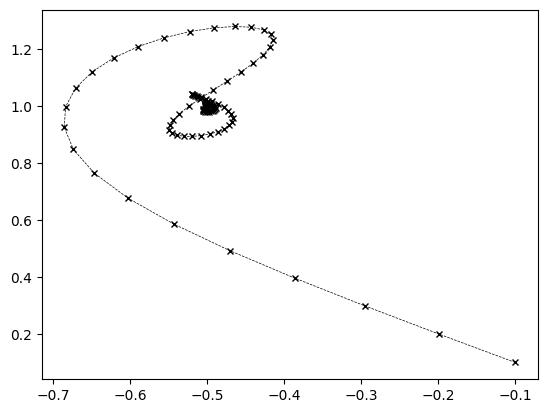

In [151]:
init_learning_rate = 1e-1
optimizer = optax.adam(init_learning_rate)

params = jnp.array([0.0, 0.0])
opt_state = optimizer.init(params)

max_num_epoch = 100
rec = []
for _ in range(max_num_epoch):
    vals, grads = jax.value_and_grad(compute_loss)(params, X, Y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    rec.append(params)

rec = np.array(rec)
plt.plot(rec[:, 0], rec[:, 1], "kx--", linewidth=0.5, markersize=5)

---
# Using `Haiku` modules
---
## Define MLP module, true parameter and generate data

{'mlp/~/linear_0': {'w': Array([[0.]], dtype=float32)}, 'mlp/~/linear_1': {'w': Array([[0.]], dtype=float32)}}


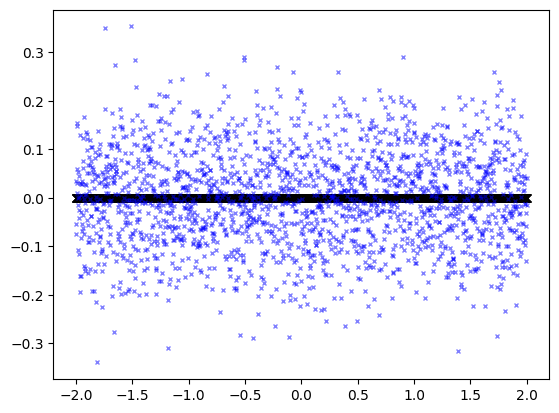

In [654]:
num_hidden_nodes = 1
output_dim = 1
num_training_data = 2023
activation_fn = jax.nn.tanh
sigma = 0.1
prior_std = 1.0
prior_mean = 0.0
w_initialiser = hk.initializers.RandomNormal(stddev=prior_std, mean=prior_mean)

@hk.transform
def forward(x):
    mlp = hk.nets.MLP(
        [num_hidden_nodes, output_dim], 
        activation=activation_fn, 
        w_init=w_initialiser,
        with_bias=False
    )
    return mlp(x)

def loss_fn(params, x, y):
    y_pred = forward.apply(params, None, x)
    return jnp.mean(optax.l2_loss(y_pred, y))

def log_prior(params):
    param_array = flatten_param_dict(params)
    return numpyro.distributions.Normal(loc=prior_mean, scale=prior_std).log_prob(param_array).sum()

def log_likelihood(params, x, y, sigma=1.0):
    loss = loss_fn(params, x, y)
    n = x.shape[0]
    return n * loss / (2 * sigma**2)

def log_posterior(params, x, y, itemp=1.0):
    return itemp * log_likelihood(params, x, y) + log_prior(params)


rngkey = hk.PRNGSequence(jax.random.PRNGKey(rngseed))
X = jnp.linspace(-2, 2, num=num_training_data).reshape(-1, 1)
true_param = forward.init(next(rngkey), X)
true_param = jax.tree_util.tree_map(lambda x: 0.0 * x, true_param)
print(true_param)
y_true = forward.apply(true_param, next(rngkey), X)
Y = y_true + jax.random.normal(next(rngkey), y_true.shape) * sigma

plt.plot(X, y_true, "kx--")
plt.plot(X, Y, "bx", markersize=3, alpha=0.5);


# print(hk.experimental.tabulate(forward)(x))

## Define `optax` optimiser

In [655]:
learning_rate = 0.1
max_num_epoch = 100

optim = optax.adam(learning_rate)

params = forward.init(next(rngkey), X)
opt_state = optim.init(params)

rec = []
for _ in range(max_num_epoch):
    grads = jax.grad(loss_fn)(params, X, Y)
    updates, opt_state = optim.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    rec.append(params)


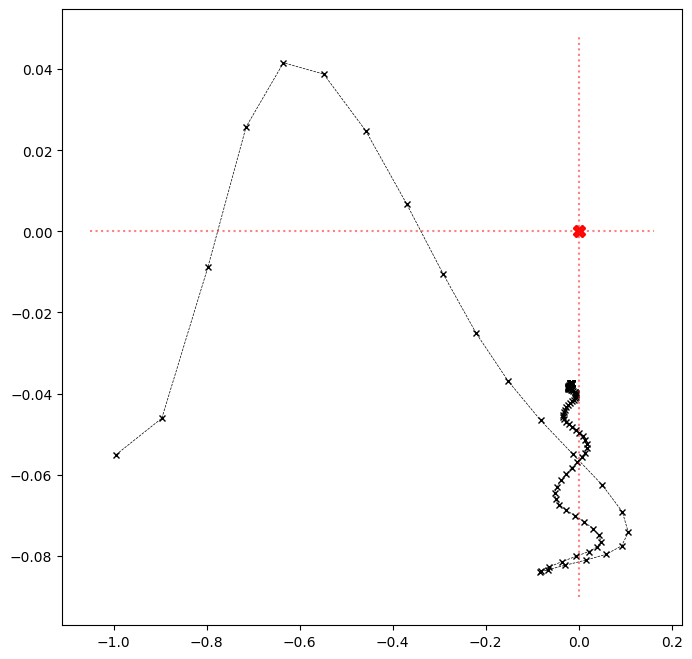

In [656]:
fig, ax = plt.subplots(figsize=(8, 8))
ws = np.array([[elem["mlp/~/linear_0"]['w'].item(), elem["mlp/~/linear_1"]['w'].item()] for elem in rec])
ax.plot(ws[:, 0], ws[:, 1], "kx--", linewidth=0.5, markersize=5)

ws_true = np.array([true_param["mlp/~/linear_0"]['w'].item(), true_param["mlp/~/linear_1"]['w'].item()])
ax.plot([ws_true[0]], [ws_true[1]], "rX", markersize=8, alpha=.8)
ax.plot([-ws_true[0]], [-ws_true[1]], "rX", markersize=8, alpha=.8)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.vlines([0], ymin=ymin, ymax=ymax, color='r', linestyle="dotted", alpha=0.5)
ax.hlines([0], xmin=xmin, xmax=xmax, color='r', linestyle="dotted", alpha=0.5)

## Sampling with Numpyro

In [661]:
num_warmup = 1000
num_posterior_samples = 2000
num_chains = 4
thinning = 4

init_params = params
# init_params = jax.tree_util.tree_map(lambda x: 0 * x + 0.1, params)

def _tree_map_func_normal_localising(kp, val):
    name = ";".join(dictkey.key for dictkey in kp)
    ones = jnp.ones(val.shape)
    return numpyro.sample(
        name, 
        numpyro.distributions.Normal(
            loc=val,
            scale=0.1 * ones
        )        
    )

def _tree_map_func_normal_fixed(kp, val):
    name = ";".join(dictkey.key for dictkey in kp)
    ones = jnp.ones(val.shape)
    return numpyro.sample(
        name, 
        numpyro.distributions.Normal(
            loc=prior_mean * ones,
            scale=0.1 * ones
        )
    )

def _tree_map_func_uniform_fixed(kp, val):
    name = ";".join(dictkey.key for dictkey in kp)
    return numpyro.sample(name, numpyro.distributions.Uniform(-0.1, 0.1), sample_shape=val.shape)



eps = 0.1
def _tree_map_func_uniform_localising(kp, val):
    name = ";".join(dictkey.key for dictkey in kp)
#     ones = jnp.ones(val.shape)
    return numpyro.sample(name, numpyro.distributions.Uniform(low=val - eps, high=val + eps))


def numpyro_model(X, Y, itemp=1.0, sigma=0.1, prior_mean=0.0, prior_std=1.0):
    param_dict = jax.tree_util.tree_map_with_path(_tree_map_func_normal_fixed, init_params)    
    y_hat = forward.apply(param_dict, None, X)
    with numpyro.plate("data", X.shape[0]):
        numpyro.sample("Y", dist.Normal(y_hat, sigma / np.sqrt(itemp)).to_event(1), obs=Y)
    return

kernel = numpyro.infer.NUTS(
    numpyro_model,
#     step_size=eps, 
#     adapt_step_size=False
)
mcmc = numpyro.infer.MCMC(
    kernel,
    num_warmup=num_warmup,
    num_samples=num_posterior_samples,
    num_chains=num_chains,
    thinning=thinning, 
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)
mcmc.run(
    jax.random.PRNGKey(45), 
    X, Y, 
    itemp=0.1, 
    sigma=sigma, 
    prior_mean=prior_mean, 
    prior_std=prior_std, 
#     init_params=jax.tree_util.tree_map(
#         lambda x: jnp.repeat(x * 0, num_chains, axis=-1).reshape(num_chains, *x.shape), 
#         init_params
#     )
)

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_49796/1909514185.py:56: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|████████████████████████████████████████████| 3000/3000 [00:00<00:00, 9012.36it/s, 7 steps of size 4.98e-01. acc. prob=0.94]


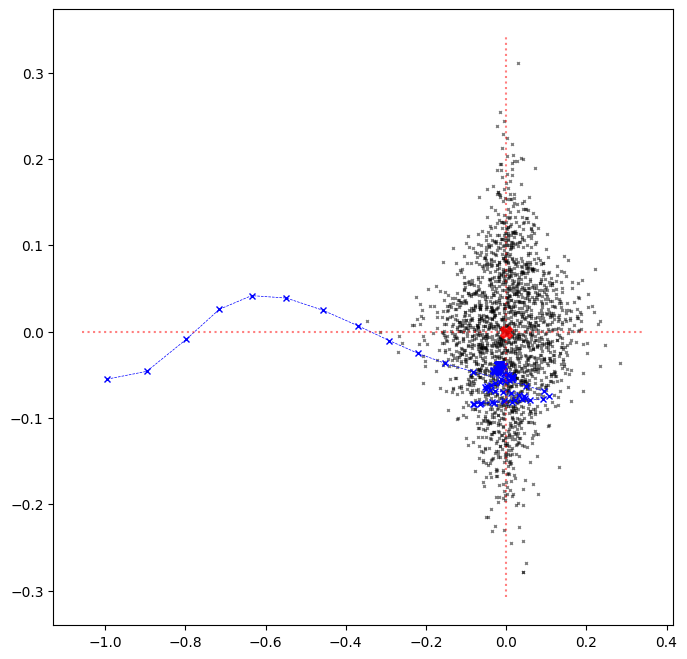

In [662]:
(s1, s2), _ = jax.tree_util.tree_flatten(mcmc.get_samples())
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(s1[:, 1, 1], s2[:, 1, 1], "kx", alpha=0.5, markersize=2)

ws = np.array([[elem["mlp/~/linear_0"]['w'].item(), elem["mlp/~/linear_1"]['w'].item()] for elem in rec])
ax.plot(ws[:, 0], ws[:, 1], "bx--", linewidth=0.5, markersize=5)

ws_true = np.array([true_param["mlp/~/linear_0"]['w'].item(), true_param["mlp/~/linear_1"]['w'].item()])
# ax.plot([ws_true[0]], [ws_true[1]], "rX", markersize=8, alpha=.8)
ax.plot([-ws_true[0]], [-ws_true[1]], "rX", markersize=8, alpha=.8)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.vlines([0], ymin=ymin, ymax=ymax, color='r', linestyle="dotted", alpha=0.5)
ax.hlines([0], xmin=xmin, xmax=xmax, color='r', linestyle="dotted", alpha=0.5)

## RLCT estimation